Models from Github: https://github.com/KordingLab/Neural_Decoding


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

'12th Grade English Essentials.gdoc'	 NMA_RNN
'12th Grade English Essentials.pdf'	'NMA working memory data .gsheet'
'BELL Cover Letter - Huixin Huang.pdf'	'PP作业课程试讲-黄慧欣 Linda.mp4'
'Colab Notebooks'			'Resume-Huixin Huang.pdf'
'Getting started.pdf'			'Transcript-Huixin Huang.pdf'
 Neural_Decoding-master			 Untitled0.ipynb


In [4]:
%cd drive/MyDrive/Neural_Decoding-master/

/content/drive/MyDrive/Neural_Decoding-master


In [5]:
! pwd

/content/drive/MyDrive/Neural_Decoding-master


In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [7]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N']      = 500                  # number of neurons
model['g']      = 0.95                 # gain of synaptic weights in pool
model['sp']     = 0.3                  # fraction of weights that are nonzero
model['tau']    = 18                   # neural membrane time constant in ms
model['dt']     = 0.1                  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x) # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn']    = 18                   # size of the input layer
model['gIn']    = 10                   # gain of the input weights
model['spIn']   = 0.1                  # sparsity of input->pool connectivity
model['burnIn'] = 10                   # time before input starts
model['durIn']  = 1                    # time for which an input is active in ms
model['ISI']    = 0                    # time between inputs in ms
model['nonlinIn'] = lambda x: x        # best to keep the input linear

In [8]:
# Look at an example input stream.
np.random.seed(2020)


# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat      = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat        = np.random.uniform(0, 1, size=(model['N'], model['N'])) \
                <= model['sp']
model['J']   = np.multiply(randMat, spMat) \
                * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn    = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn      = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) \
                <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) \
                * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [9]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.
  
  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])
  

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)
    
  input_stream = np.array(input_stream)
  print(input_stream.shape)
  
  onehot = np.zeros((model['nIn']+1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:,:]

  return onehot, input_stream


def make_special_input(sequence_length, model, start_fire_fromIn, stop_fire_fromIn):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])
  input_stream.extend([0] * int(start_fire_fromIn/model['dt']))

  for i in range(start_fire_fromIn , stop_fire_fromIn):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream.extend([0] * int((sequence_length - stop_fire_fromIn)/model['dt']))

  input_stream = np.array(input_stream)
  print(input_stream.shape)
  
  onehot = np.zeros((model['nIn']+1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:,:]

  return onehot, input_stream

(600,)


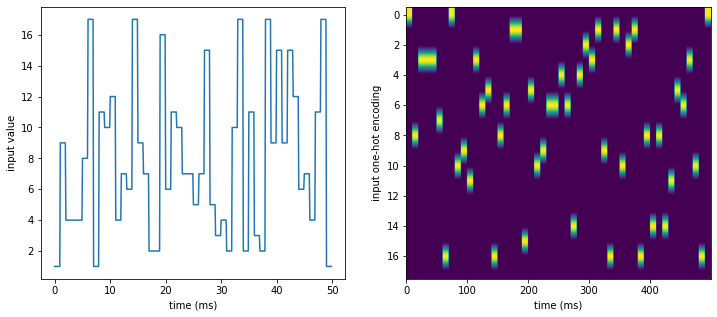

In [10]:
# Look at an example input stream.
np.random.seed(2020)

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:]);
ax[0].set_xlabel('time (ms)');
ax[0].set_ylabel('input value');

ax[1].imshow(onehot[:, omit:], aspect='auto');
ax[1].set_xlabel('time (ms)');
ax[1].set_ylabel('input one-hot encoding');

(5100,)


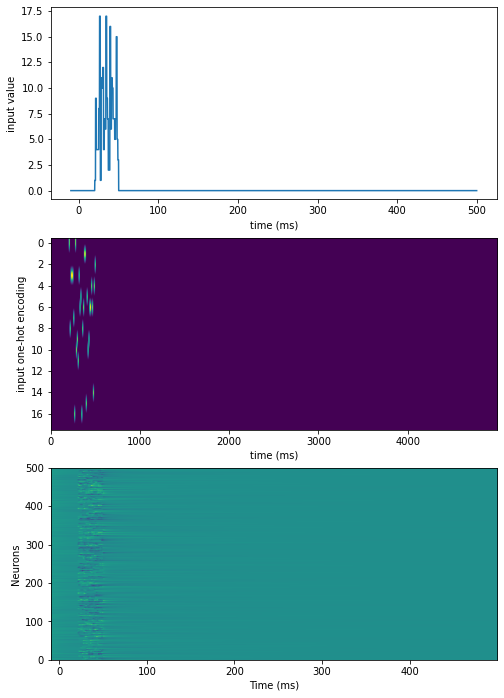

In [11]:
# Look at an example special input stream _ 2.
np.random.seed(2020)

onehot_2, input_stream_2 = make_special_input(500, model, 20, 50)

# initialize the firing rates randomly
firing_rates_2 = np.zeros((model['N'], len(input_stream_2)))
firing_rates_2[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream_2)-1):
  firing_rates_2[:,t+1] = step(firing_rates_2[:,t], onehot_2[:,t], model)


fig, ax = plt.subplots(3, 1, figsize=(8, 12))
simulation_time_2 = np.arange(len(input_stream_2))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time_2, input_stream_2);
ax[0].set_xlabel('time (ms)');
ax[0].set_ylabel('input value');

ax[1].imshow(onehot_2[:, omit:], aspect='auto');
ax[1].set_xlabel('time (ms)');
ax[1].set_ylabel('input one-hot encoding');

extents = [simulation_time_2[0],simulation_time_2[-1], 0, model['N']]
ax[2].imshow(firing_rates_2, aspect='auto', extent=extents);
ax[2].set_xlabel('Time (ms)');
ax[2].set_ylabel('Neurons');

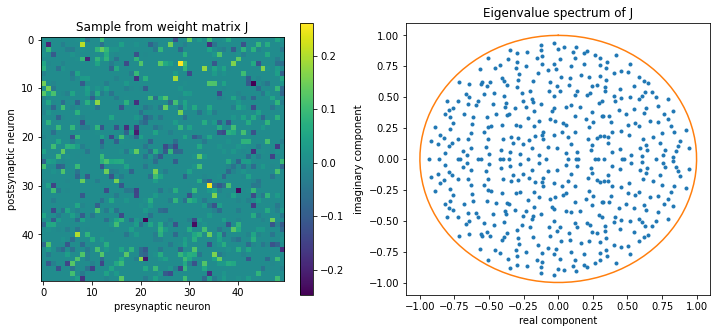

In [12]:
np.random.seed(2020)


# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h=ax[0].imshow(model['J'][:showCount,:showCount]);
ax[0].set_title('Sample from weight matrix J');
ax[0].set_xlabel('presynaptic neuron');
ax[0].set_ylabel('postsynaptic neuron');
plt.colorbar(h, ax=ax[0]);

ax[1].plot(np.real(w),np.imag(w),'.');
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100))); # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component');
ax[1].set_ylabel('imaginary component');

(10000,)


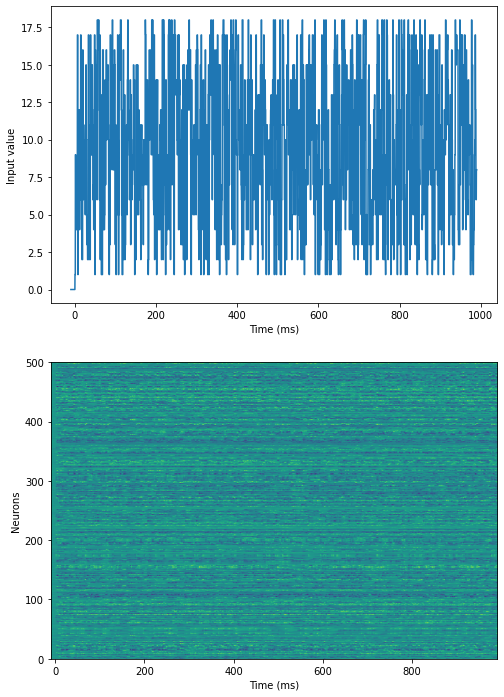

In [13]:
# Look at an example input stream.
np.random.seed(2020)

# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(990, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream);
ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Input value');

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents);
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Neurons');

### 数据初始化

In [14]:
firing_rates.shape

(500, 10000)

In [15]:
firing_rates = firing_rates.T

In [16]:
firing_rates.shape

(10000, 500)

In [17]:
firing_rates

array([[ 0.02685752,  0.03689366,  0.08581322, ...,  0.05589638,
         0.03142124,  0.06164794],
       [ 0.02682773,  0.03666327,  0.08518306, ...,  0.05567547,
         0.03092444,  0.06122228],
       [ 0.02679587,  0.03643656,  0.08456098, ...,  0.05545389,
         0.03043204,  0.06079836],
       ...,
       [ 0.13090724,  0.14698749,  0.09415603, ..., -0.06832178,
         0.06552491, -0.17017041],
       [ 0.13022442,  0.14560863,  0.09339707, ..., -0.06744801,
         0.07491656, -0.16595333],
       [ 0.12952891,  0.14421512,  0.09266492, ..., -0.06658113,
         0.08421842, -0.1618042 ]])

In [18]:
y = input_stream
y = y.reshape(-1,1)
y.shape

(10000, 1)

In [19]:
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
bins_before=3 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=3 #How many bins of neural data after the output are used for decoding

In [21]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(firing_rates,bins_before,bins_after,bins_current)
print(y.shape)
print(X.shape)

(10000, 1)
(10000, 7, 500)


In [22]:
X[0,0,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [23]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

In [24]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
y_valid=y[valid_set,:]

In [25]:
print(training_set)

print(testing_set)

print(valid_set)

[   3    4    5 ... 6994 6995 6996]
[7003 7004 7005 ... 8494 8495 8496]
[8503 8504 8505 ... 9994 9995 9996]


In [26]:
#Z-score "X" inputs. 
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std


#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

In [27]:
#Declare model
model_lstm=LSTMDecoder(units=500,dropout=0,num_epochs=5)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

R2s: [0.8259364]


In [28]:
#Declare model
model_rnn=SimpleRNNDecoder(units=500,dropout=0,num_epochs=5)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

R2s: [0.89628146]


#### validating data

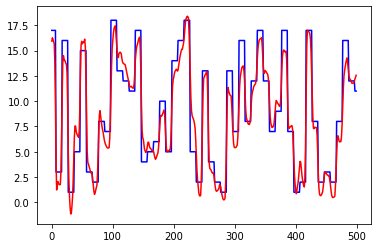

In [29]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[0:500,0]+y_train_mean[0],'b')
plt.plot(y_valid_predicted_rnn[0:500,0]+y_train_mean[0],'r')

#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')

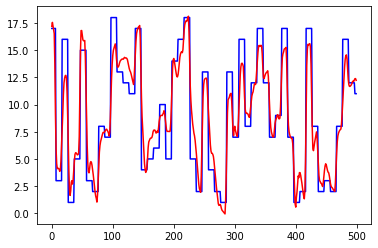

In [30]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[0:500,0]+y_train_mean[0],'b')
plt.plot(y_valid_predicted_lstm[0:500,0]+y_train_mean[0],'r')

#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')

#### Testing data

In [31]:
y_test_predicted_rnn=model_rnn.predict(X_test)

R2s: [0.89882619]


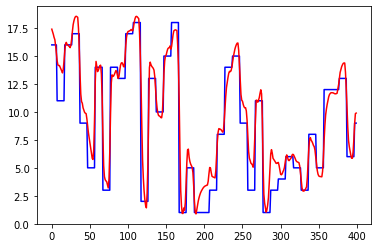

In [32]:
fig_x_wf=plt.figure()
plt.plot(y_test[100:500,0]+y_train_mean[0],'b')
plt.plot(y_test_predicted_rnn[100:500,0]+y_train_mean[0],'r')
#Get metric of fit
R2s_rnn=get_R2(y_test,y_test_predicted_rnn)
print('R2s:', R2s_rnn)

In [33]:
y_test_predicted_lstm=model_lstm.predict(X_test)

R2s: [0.85151271]


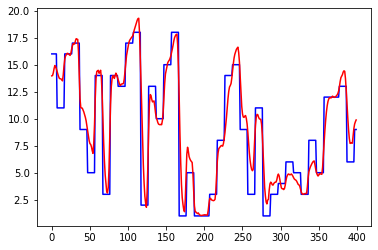

In [34]:
fig_x_wf=plt.figure()
plt.plot(y_test[100:500,0]+y_train_mean[0],'b')
plt.plot(y_test_predicted_lstm[100:500,0]+y_train_mean[0],'r')
#Get metric of fit
R2s_lstm=get_R2(y_test,y_test_predicted_lstm)
print('R2s:', R2s_lstm)

# Testing Special Input Data

In [35]:
y_2 = input_stream_2
y_2 = y_2.reshape(-1,1)

In [36]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X_2=get_spikes_with_history(firing_rates_2.T,bins_before,bins_after,bins_current)
print(firing_rates_2.shape)
print(y_2.shape)
print(X_2.shape)

(500, 5100)
(5100, 1)
(5100, 7, 500)


In [37]:
#Get predictions for RNN
y_2_predicted_rnn=model_rnn.predict(X_2)

#Get metric of fit
R2s_rnn_2=get_R2(y_2,y_2_predicted_rnn)
print('R2s:', R2s_rnn_2)

R2s: [nan]


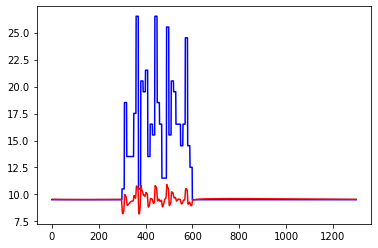

In [38]:
plt.plot(y_2[0:1300,0]+y_train_mean[0],'b')
plt.plot(y_2_predicted_rnn[0:1300,0]+y_train_mean[0],'r')

In [39]:
#Get predictions for LSTM
y_2_predicted_lstm=model_lstm.predict(X_2)

#Get metric of fit
R2s_lstm_2=get_R2(y_2,y_2_predicted_lstm)
print('R2s:', R2s_lstm_2)

R2s: [nan]


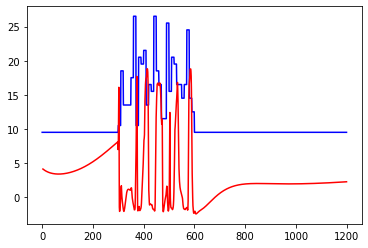

In [40]:
plt.plot(y_2[0:1200,0]+y_train_mean[0],'b')
plt.plot(y_2_predicted_lstm[0:1200,0]+y_train_mean[0],'r')


# Testing the memory!
##### Building new input for 20000ms to testing the decoder performance and memory capacity

New Input 

In [41]:
def Make_Input_and_Firingrate(timestep, plot=False):
  # Simulate the model activity.

  # generate the input to the model
  onehot, input_stream = make_input(timestep, model)

  # initialize the firing rates randomly
  firing_rates = np.zeros((model['N'], len(input_stream)))
  firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

  for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

  if plot:

    fig, ax = plt.subplots(2, 1, figsize=(8, 12))
    simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
    ax[0].plot(simulation_time, input_stream);
    ax[0].set_xlabel('Time (ms)');
    ax[0].set_ylabel('Input value');

    extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
    ax[1].imshow(firing_rates, aspect='auto', extent=extents);
    ax[1].set_xlabel('Time (ms)');
    ax[1].set_ylabel('Neurons');

  return firing_rates, input_stream

In [42]:
np.random.seed(10)
firing_rates, input_stream = Make_Input_and_Firingrate(timestep=3990,plot=False)

(40000,)


In [43]:
def test_memory(timebegin, timestep):
  ## timebegin: the time of testing data from the timebegining to the end.
  ## timestep: the whole timing of the data set 

  firing_rates, input_stream = Make_Input_and_Firingrate(timestep=1990,plot=False)
  firing_rates = firing_rates.T
  y = input_stream.reshape(-1,1)

  # the X dataset
  bins_before=6 #How many bins of neural data prior to the output are used for decoding
  bins_current=1 #Whether to use concurrent time bin of neural data
  bins_after=6 #How many bins of neural data after the output are used for decoding
  # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
  # Function to get the covariate matrix that includes spike history from previous bins
  X = get_spikes_with_history(firing_rates,bins_before,bins_after,bins_current)

  testing_range=[timebegin, 1]

In [44]:
firing_rates.shape

(500, 40000)

In [45]:
firing_rates = firing_rates.T
y = input_stream.reshape(-1,1)

In [46]:
bins_before=3 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=3 #How many bins of neural data after the output are used for decoding

In [47]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X = get_spikes_with_history(firing_rates,bins_before,bins_after,bins_current)
print(y.shape)
print(X.shape)

(40000, 1)
(40000, 7, 500)


In [48]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.5]
testing_range=[0.5, 1]

In [49]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)


#Get training data
X_train=X[training_set,:,:]
# X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
# X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]


In [50]:
#Z-score "X" inputs. 
X_test_mean=np.nanmean(X_test,axis=0)
X_test_std=np.nanstd(X_test,axis=0)
X_test=(X_test-X_test_mean)/X_test_std


#Zero-center outputs
y_test_mean=np.mean(y_test,axis=0)
y_test=y_test-y_test_mean

In [51]:
#Get predictions
y_test_predicted_rnn = model_rnn.predict(X_test)

#Get metric of fit
R2s_rnn = get_R2(y_test,y_test_predicted_rnn)
print('R2s:', R2s_rnn)

R2s: [0.87520407]


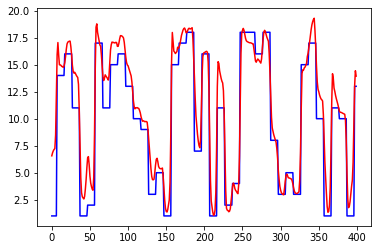

In [52]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_test[100:500,0]+y_test_mean[0],'b')
plt.plot(y_test_predicted_rnn[100:500,0]+y_test_mean[0],'r')

#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')

In [53]:
import os
import torch
import torchvision


In [54]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

AttributeError: ignored